<a href="https://colab.research.google.com/github/dianabohorquez/spotify/blob/main/TimeSeries_VAR_Spotify.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introducción

El modelo de vectores autorregresivos (VAR) es un algoritmo de pronóstico multivariado usado para analizar la influencia de dos o mas series temporales entre ellas.

Una de las principales diferencias entre este modelo y los modelos ARIMA (además del evidente hecho de trabajar no solo con los propios lags de una variable sino con los lags de otras variables) es que estos últimos son unidireccionales mientras que los VAR son bi-direccionales, es decir se analiza como las variables se influencian una de la otra.

Esta notebook continúa con el análisis de series temporales en características de audio de canciones en Spotify, pero desde un enfoque multivariado. Para esto se desarrollarán los siguientes pasos:

* Análisis de las características de las series temporales
* Testeo de estacionarieadad; transformación, si es necesario
* Testeo de su causalidad en el sentido de Granger
* Análisis de función impulso respesta
* Encontrar el valor óptimo de *(p)*
* Ajuste del modelo
* Destranformar la serie, si es necesario
* Evaluación del modelo
* Pronostico del futuro

Dados los resultados con las variables iniciales, se corren paralelamente dos experimentos: el primero con nuevas variables del mismo dataset y un segundo con las variables originales pero aplicando el algoritmo de Prophet.

Además de las referencias presentadas en el marco teórico de trabajo integrador, las siguientes páginas ayudaron a construir esta notebook de Python.

- [Granger Causality Statistical Test for Time Series](https://www.youtube.com/watch?v=51Yy11Vy_4Y&ab_channel=AIEngineering)
- [Time Series Analysis. VAR Model](https://github.com/ritvikmath/Time-Series-Analysis/blob/master/VAR%20Model.ipynb)
- [Multivariate Time series using Vector Autoregression (VAR)](https://www.youtube.com/watch?v=TpQtD7ONfxQ&t=43s&ab_channel=AIEngineering)
- [Vector Autoregression (VAR) – Comprehensive Guide with Examples in Python](https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/)
- [Forecasting using Granger’s Causality and Vector Auto-regressive Model](https://towardsdatascience.com/granger-causality-and-vector-auto-regressive-model-for-time-series-forecasting-3226a64889a6)
- [Multivariate Time Series Modeling using Facebook Prophet](https://youtu.be/XZhPO043lqU)
- [Multivariate Time Series Modeling using Facebook Prophet - Script](https://github.com/srivatsan88/End-to-End-Time-Series/blob/master/Time_Series_using_Prophet_for_Multivariate.ipynb)
- [Time Series Forecasting with Facebook Prophet and Python in 20 Minutes](https://youtu.be/KvLG1uTC-KU)



### Preparación del entorno

In [ ]:
# manipulación de data frames y EDA
import pandas as pd
import numpy as np

# visualización
import matplotlib.pyplot as plt
import seaborn as sns

# paquetes estadísticos - modelado de series temporales
import statsmodels.api as sm                                   # modelos estadísticos
from statsmodels.tsa.stattools import adfuller                 # test Dickey-Fuller
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf  # plot the (P)ACF
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests
from scipy.stats import pearsonr

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# accessing to google
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)   #to attempt to forcibly remount  force_remount

# setting working directory
import os
os.chdir("/content/gdrive/My Drive/Data Scientist/spotify/datasets/")

# Planteamiento del Problema

Si se refiere a datos de YouTube, Netflix o Spotify instintivamente  cualquiera puede responder qué producción musical o audiovisual  es un hit: si lleva tiempo siendo muy vista o escuchada o si rompió algún record de visitas estamos ante un producto *pop*. Para el caso de Spotify, en su [página de desarrollador](https://developer.spotify.com/documentation/web-api/reference/#endpoint-get-audio-features) ellos mencionan, por ejemplo, que la `popularity` de una canción es de hecho un valor calculado por un algoritmo basado, en mayor medida, en la cantidad de reproducciones que tiene una canción. Pero, ¿cómo se puede explicar esta popularidad?

Spotify ha estructurado información no estructurada para *explicar* en términos de datos la música, definiendo variables como `loudness` (volumen general de una pista en dB), `liveness` (probabilidad  que el track se realizó en vivo) o `acousticness` (medida de confianza de si la pista es acústica o no). UUna breve exploración de estas y otras variables se encuentra en la [notebook A01_EDA](https://github.com/dianabohorquez/spotify/blob/main/A01_EDA_Spotify.ipynb).

De acuerdo a esa exploración, a la oportunidad de buscar analizar series de comportamiento no estacionario y a la definición que Spotify da a sus variables, se preseleccionaron para este trabajo práctico `energy` y `valence`.

- **release_date** contiene la fecha de lanzamiento, la mayoría con formato yyyy-mm-dd.
- **energy** con un rango de 0.0 a 1.0 representa una medida perceptiva de intensidad y actividad. Por lo general, las pistas enérgicas se sienten rápidas y ruidosas. Por ejemplo, el death metal tiene mucha energía, mientras que un preludio de Bach tiene una puntuación baja en la escala. Las características de percepción que contribuyen a este atributo incluyen rango dinámico, volumen percibido, timbre, frecuencia de inicio y entropía general.
- **valence**: con un rango de 0.0 a 1.0 `valence` describe la positividad musical que transmite una pista. Las pistas con valencia alta suenan más positivas (por ejemplo, feliz, alegre, eufórico), mientras que las pistas con valencia baja suenan más negativas (para el caso de adjetivos como triste, deprimido, enojado).
- **danceability**: danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable.

Varios datasets de Spotify están disponible en [Kaggle](https://www.kaggle.com/yamaerenay/spotify-dataset-19212020-160k-tracks). Particularmente para este trabajo práctico se utilizará  `data_o.csv`, renombrado `spotify_o.csv.zip`

Es interés para este trabajo práctico pronosticar el comportamiento futuro de estas tres variables haciendo uso de análisis de series temporales.

REESCRIBIR LO DE ARRIBA
Y SUMAR QUE TRABAJARÉ ADEMÁS CON LA SERIE `popularity`

# Modelos de Vectores Autorregresivos



## EDA de series temporales y preprocesamiento

En la notebook [TimeSeries ARIMA Spotify](https://github.com/dianabohorquez/spotify/blob/main/TimeSeries_ARIMA_Spotify.ipynb) se exploraron en detalle las variables `valence` y `energy`, por lo cual no se profundizará en detalles explorados en dicha notebook. Para este trabajo se incluye la variable `popularity` en la cual se trabajará sin un profundo nivel de detalle explicativo.

En cuanto a su tratamiento, en dicha notebook se tomaron algunas decisiones que aquí se replicarán desde el inicio.

In [3]:
# importación de datos
spotify = pd.read_csv('spotify_o.csv.zip', usecols=['release_date', 'energy', 'valence', 'popularity'], index_col='release_date', parse_dates=True)

# Eliminado los datos menores a 1960 (inclusive) y agrupándolos según su promedio trimestral
spotify = spotify.groupby(pd.Grouper(freq="Q")).mean()
spotify = spotify.iloc[160:,]   # 160 para Q, 40 para A

spotify.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 240 entries, 1961-03-31 to 2020-12-31
Freq: Q-DEC
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   valence     240 non-null    float64
 1   energy      240 non-null    float64
 2   popularity  240 non-null    float64
dtypes: float64(3)
memory usage: 7.5 KB


**Las tres variables pueden pensarse como una normalmente distribuidas, aunque energy con un claro sesgo negativo y `valence` con uno ligero**

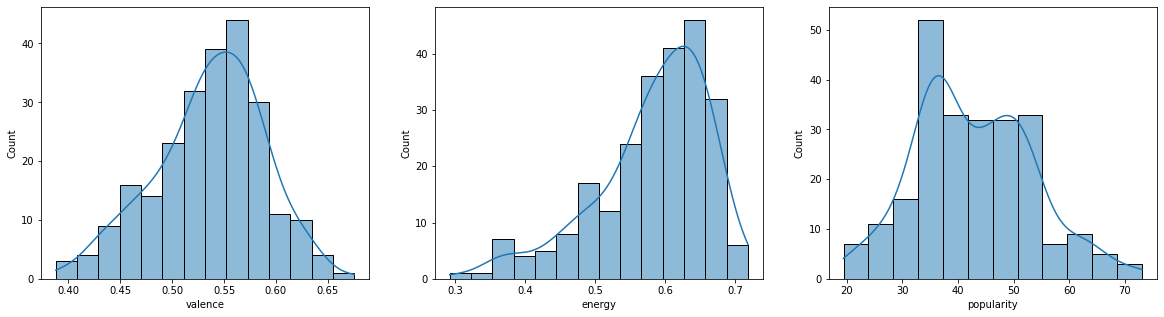

In [4]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

sns.histplot(data=spotify, x="valence", kde=True, ax=axs[0]);
sns.histplot(data=spotify, x="energy", kde=True, ax=axs[1]);
sns.histplot(data=spotify, x="popularity", kde=True, ax=axs[2]);

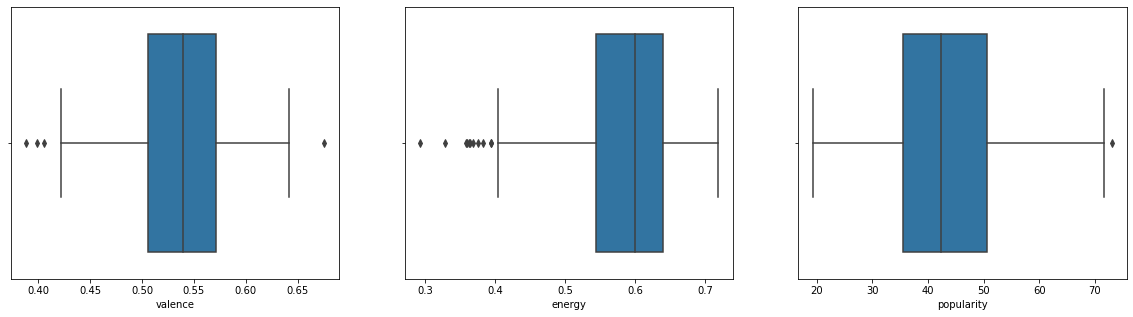

In [5]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

sns.boxplot(data=spotify, x="valence", ax=axs[0]);
sns.boxplot(data=spotify, x="energy", ax=axs[1]);
sns.boxplot(data=spotify, x="popularity", ax=axs[2]);

**Visualmente ninguna de las series parece estacionaria.**

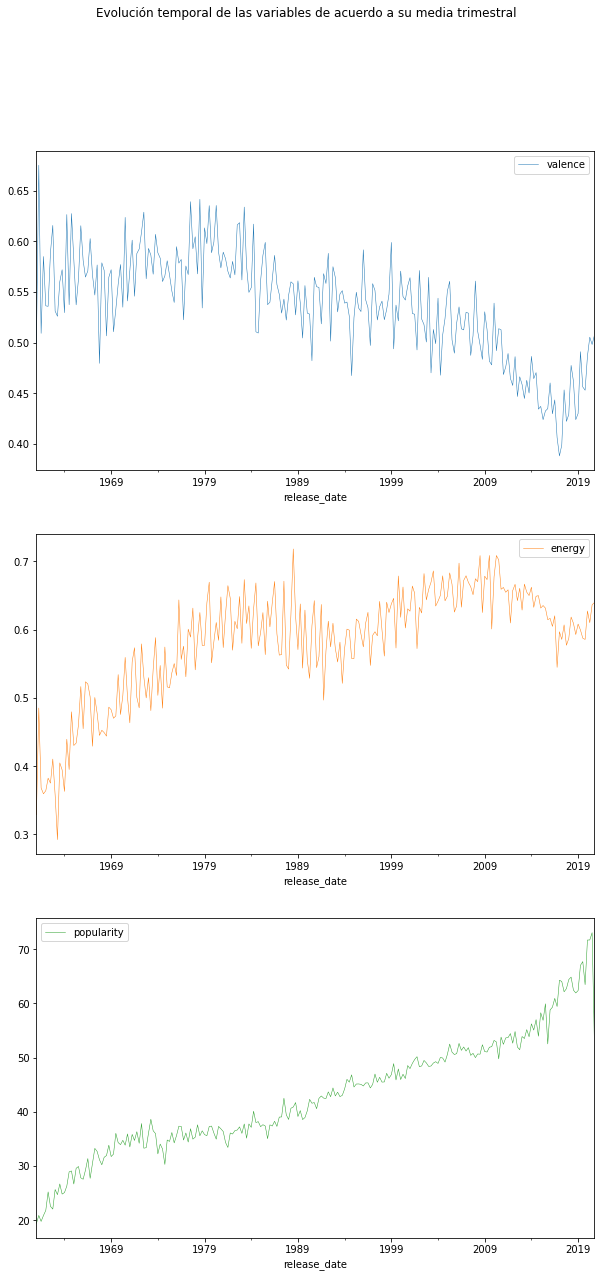

In [108]:
spotify.plot(subplots=True
             , linewidth=0.5, layout=(3, 1), figsize=(10, 20)
             , sharex=False, sharey=False
             , title = 'Evolución temporal de las variables de acuerdo a su media trimestral');

## Tratamiento de la tendencia

Para comprobar lo observado gráficamente se corre el test ADF evidenciándose de acuerdo a los p-value que no se puede rechazar H0, de tal forma que no se puede asumir estacionariedad en cada una de las series.

Aunque en la serie `energy` sí se rechaza H0, se había comentado que bajo el test KPSS esta serie temporal no es estacionaria.

In [7]:
for col in range(len(spotify.columns)):
  result = adfuller(spotify[spotify.columns[col]])

  if result[1] > 0.05 :
    print('{} - Serie es no estacionaria: p-value:{}'.format(spotify.columns[col], result[1]))
  else:
    print('{} - Serie es estacionaria: p-value:{}'.format(spotify.columns[col], result[1]))

valence - Serie es no estacionaria: p-value:0.3980382475045702
energy - Serie es estacionaria: p-value:0.017150791572558437
popularity - Serie es no estacionaria: p-value:0.9434694773420735


In [9]:
# Aplicando diferencia al dataset
spotifyDiff = spotify.diff().dropna()

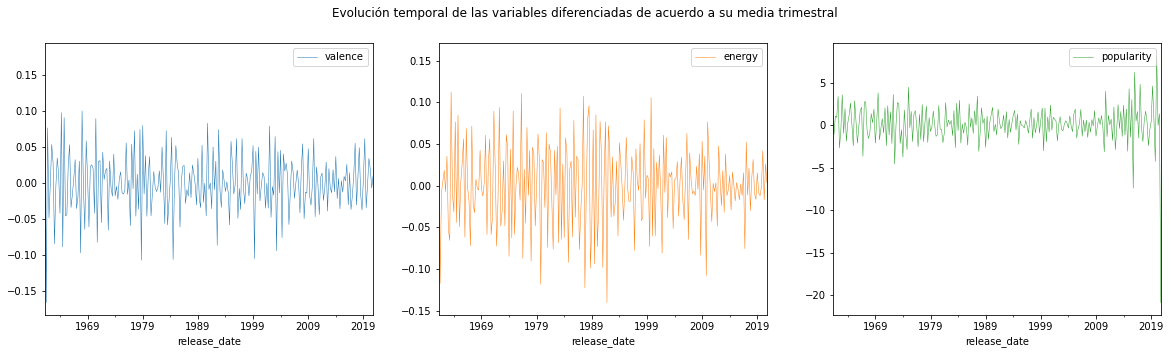

In [10]:
spotifyDiff.plot(subplots=True
                 , linewidth=0.5, layout=(1, 3), figsize=(20, 5)
                 , sharex=False, sharey=False
                 , title = 'Evolución temporal de las variables diferenciadas de acuerdo a su media trimestral');

In [11]:
for col in spotifyDiff.columns:
    print('p-value del Test ADFuller para', col,': ', adfuller(spotifyDiff[col])[1])

p-value del Test ADFuller para valence :  2.9421281845410765e-30
p-value del Test ADFuller para energy :  1.1011008283258128e-24
p-value del Test ADFuller para popularity :  1.1850560934819994e-13


## Causalidad en el sentido de Granger

La idea básica detrás de los modelos VAR es cada serie temporal del sistema influencia a las demás. Usando el test de causalidad en el sentido de Granger se puede probar la hipótesis de si el pasado de una serie temporal es útil para predicir otra serie temporal.

La hipótesis nula de este test establece que los coeficientes de los lags en la ecuación de regresión son cero, dicho de otra forma, que los valores pasados de la serie temporal $x$ no "causan" a la serie $y$.

A continuación, se testearán todos los posibles combinaciones con diferentes números de lags de las series temporales.

In [12]:
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):
    """
    Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values.
    
    P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

**Para la lectura de Los resultado de la definición `grangers_causation_matrix()` considerar lo siguiente:**

1. Las series temporales $y$ (es decir las filas), se explican en el sentido de Granger en función de las variables $x$ (representadas en las columnas).
2. Las celdas contienen el p-value del test de Granger.
3. El programa itera hasta el valor lag máximo definido y en la matriz resumen se muestra el menor p-value obtenido, pero no indica en que lag obtuvo ese *p valor*.

**Recién en el lag 10 se ve que `valence` causa en el sentido de Granger a `energy` y antes de este lag no lo hace. Los resultados no muestran una relación causal inversa.**

In [13]:
maxlag = 10
grangers_causation_matrix(spotifyDiff, variables = spotifyDiff.columns)

,valence_x,energy_x,popularity_x
valence_y,1.0000,0.1878,0.2901
energy_y,0.0243,1.0000,0.4223
popularity_y,0.3401,0.1356,1.0000


**En el lag 14 ya la causalidad en el sentido de Granger bidireccional entre `energy`-`valence`-`energy` aparece**

In [14]:
maxlag = 14
grangers_causation_matrix(spotifyDiff, variables = spotifyDiff.columns)

,valence_x,energy_x,popularity_x
valence_y,1.0000,0.0244,0.1903
energy_y,0.0039,1.0000,0.4223
popularity_y,0.3401,0.1356,1.0000


In [15]:
maxlag = 21
grangers_causation_matrix(spotifyDiff, variables = spotifyDiff.columns)

,valence_x,energy_x,popularity_x
valence_y,1.0000,0.0158,0.0431
energy_y,0.0000,1.0000,0.0848
popularity_y,0.1157,0.1356,1.0000


**En el lag 24 y posteriormente en el 27 según la prueba estadística muestra que la serie temporale `popularity` se explica en el sentido de Granger en función de las series temporales `valence` y `energy`**

In [16]:
maxlag = 24   # esto son seis años
grangers_causation_matrix(spotifyDiff, variables = spotifyDiff.columns)

,valence_x,energy_x,popularity_x
valence_y,1.0000,0.0158,0.0224
energy_y,0.0000,1.0000,0.0848
popularity_y,0.0257,0.1353,1.0000


In [17]:
maxlag = 27
grangers_causation_matrix(spotifyDiff, variables = spotifyDiff.columns)

,valence_x,energy_x,popularity_x
valence_y,1.0000,0.0158,0.0224
energy_y,0.0000,1.0000,0.0848
popularity_y,0.0007,0.0500,1.0000


**Para que todas las variables sean causales de las otras en el sentido de Granger hay que esperar hasta el lag 35.**

In [18]:
maxlag = 35
grangers_causation_matrix(spotifyDiff, variables = spotifyDiff.columns)

,valence_x,energy_x,popularity_x
valence_y,1.0000,0.0003,0.0156
energy_y,0.0000,1.0000,0.0392
popularity_y,0.0007,0.0144,1.0000


**En caso de querer explorar los diferentes p-values, a diferentes lags y con diferentes test, eligiendo un par de variables a la vez, puede correrse las siguientes líneas de código.**

In [19]:
#grangercausalitytests(df[['y', 'x']], lags)
valene = spotifyDiff[['valence', 'energy']]
gc_vle = grangercausalitytests(valene, 2)

# Hipótesis:
# H0: 'serie y' no causa en el sentido de Granger a 'serie x' -> p-value > 0.05 no rechazo H0
# H1: 'serie y' causa en el sentido de Granger a 'serie x'    -> p-value < 0.05 rechazo H0

# Explicación del resultado
# - Hay 4 test hechos sobre cada lag lag
# - viendo el p-value, en este caso están lejos del 0.05, entonces
#   podemos estar seguros que energy no causa en sentido de Granger
#   a valence.

# H0: valence no se explica en función de energy hasta el lag 13; en el lag 14
# H0: valence se explica en función de energy en el lag 14


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2106  , p=0.6467  , df_denom=235, df_num=1
ssr based chi2 test:   chi2=0.2133  , p=0.6442  , df=1
likelihood ratio test: chi2=0.2132  , p=0.6443  , df=1
parameter F test:         F=0.2106  , p=0.6467  , df_denom=235, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.6372  , p=0.1968  , df_denom=232, df_num=2
ssr based chi2 test:   chi2=3.3449  , p=0.1878  , df=2
likelihood ratio test: chi2=3.3215  , p=0.1900  , df=2
parameter F test:         F=1.6372  , p=0.1968  , df_denom=232, df_num=2


**Este set de experimentos no está diseñado para concluir o afirmar categóricamente si una variable causa a la otra (siempre en el sentido de Granger), sino para dar una intuición acerca de la interacción entre las variables y sus lags. Corresponde al analista y de acuerdo al conocimiento que tenga en el tema tomar las decisiones considerando la información brindada por los tests**

**Sin embargo, es llamativo ver cómo tienen que pasar tantos lags (10 que se traducen en 30 meses) para ver una primera relación entre dos variables, y pone en duda si la inclusión del pasado de las variables `valence` y `energy` realmente contribuyen al pronóstico de la popularidad de una canción**

## Test de Cointegración

La prueba de cointegración ayuda a establecer la presencia de una conexión estadísticamente significativa entre dos o más series de tiempo.

Cuando tiene dos o más series de tiempo, y existe una combinación lineal de ellas que tiene un orden de integración (d) menor que el de la serie individual, entonces se dice que la colección de series está cointegrada. Cuando dos o más series de tiempo están cointegradas, significa que tienen una relación estadísticamente significativa a largo plazo.

Esta es la premisa básica en la que se basan los modelos de autorregresión vectorial (VAR). Por lo tanto, es bastante común implementar la prueba de cointegración antes de comenzar a construir modelos VAR.

Performing a cointegration test IS necessary to establish a long-run relationship... That is, we can assume a long run relationship in the model despite the fact the series are drifting apart or trending either upward or downward

Hay dos test de cointegración par I(I), el Engle-Granger y el de Cointegración de Johansen test:

H0: no hay cointegración equation
H1: H0 is not true H0

Este test debe hacerse con las variables originales o puede ser con la transformación logarítmica, pero no habiéndose diferenciado.

In [20]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

In [21]:
def cointegration_test(df, retardo, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1, retardo)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat | C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), "|", adjust(cvt, 8), ' =>  ' , trace > cvt)

**Si el test es mayor que el valor crítico se rechaza H0, entonces hay evidencia estadística que hay cointegración.**

In [22]:
cointegration_test(spotify, retardo=1)

Name   ::  Test Stat | C(95%)    =>   Signif  
 ----------------------------------------
valence ::  29.17     | 24.2761   =>   True
energy ::  6.29      | 12.3212   =>   False
popularity ::  0.68      | 4.1296    =>   False


**Dado este test, hay evidencia que ninguna de las variables tiene una relación a largo tiempo en el modelo.**

## Construcción del modelo VAR

### Estimando el orden del modelo

Para estimar el orden del modelo VAR se pueden graficar las funciones de autocorrelaciones parciales de las series; en estas *se sugiere un modelo VAR(3)*

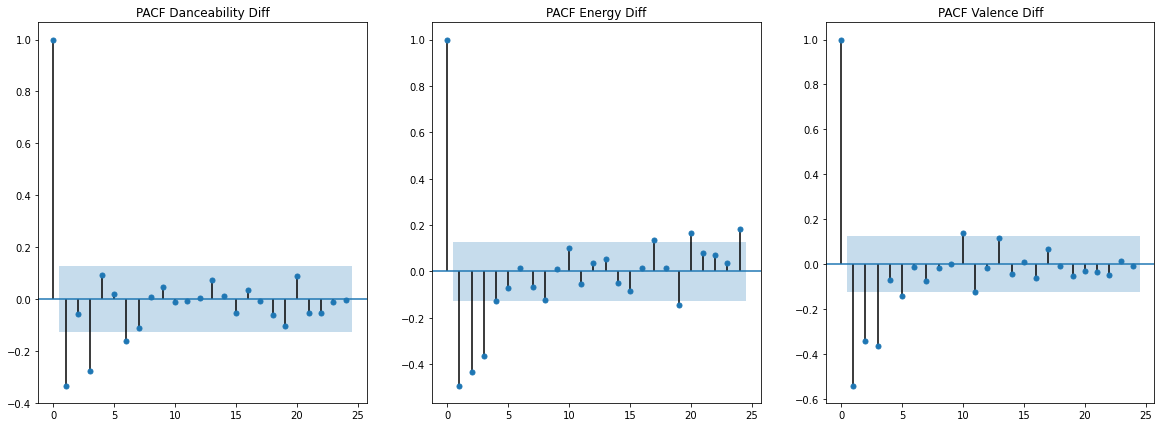

In [23]:
#@title
# Gráfica ACF y PACF de danceability
fig, axes = plt.subplots(1, 3, figsize=(20, 7))
plot_pacf(spotifyDiff['valence'], ax=axes[2], title='PACF Valence Diff');
plot_pacf(spotifyDiff['energy'], ax=axes[1], title='PACF Energy Diff');
plot_pacf(spotifyDiff['popularity'], ax=axes[0], title='PACF Danceability Diff');

**Si corremos un modelo VAR en un rango amplio de lags, vemos que según diferentes criterios de información el mejor orden para el ajuste del modelo es VAR(3)**

In [24]:
model = VAR(spotifyDiff, freq="Q")
for i in range(10):
    results = model.fit(i+1)
    #print('Order = ', i+1)
    #print('AIC: ', results.aic)
    #print('BIC: ', results.bic)

model.select_order(10).summary()

,AIC,BIC,FPE,HQIC
0,-10.80,-10.76,2.036e-05,-10.78
1,-11.53,-11.35,9.828e-06,-11.46
2,-11.85,-11.53,7.160e-06,-11.72
3,-12.31*,-11.87*,4.485e-06*,-12.13*
4,-12.26,-11.68,4.734e-06,-12.03
5,-12.25,-11.53,4.803e-06,-11.96
6,-12.22,-11.36,4.946e-06,-11.87
7,-12.26,-11.27,4.764e-06,-11.86
8,-12.21,-11.09,4.982e-06,-11.76
9,-12.16,-10.90,5.277e-06,-11.65


Una tercera opción que se correrá es comparar la correlación entre los diferentes lags de las variables (para el caso del lag 1 hasta el 36)

En los resultados, el primer número es la correlación entre el lag entre la serie `popularity` y el lag de `energy`, y el segundo número es la significancia de esta correlación, es decir el *p-value*, que naturalmente debe ser menor a 0.05. Para este caso recién está en el lag 16.

Esto nos indica que quizás el lag 16 puede ser significantivo cuando se trata de predecir la serie temporal `popularity` basado en los lags values de la serie temporal `energy`.

En palabras de negocio, esto significa que deben pasar 48 meses (4 años) para que un lag de `energy` sea significante.

In [25]:
for lag in range(1, 36):
    series = spotifyDiff['popularity'].iloc[lag:]
    lagged_series = spotifyDiff['energy'].iloc[:-lag]
    print('Lag: %s'%lag, pearsonr(series, lagged_series))

Lag: 1 (-0.1071468998187231, 0.09914155051879514)
Lag: 2 (-0.05815744480756169, 0.3727449085878465)
Lag: 3 (0.045364942588205955, 0.48795419709713905)
Lag: 4 (0.04333800148816439, 0.5085307532252966)
Lag: 5 (-0.058453116006728194, 0.3733940315278008)
Lag: 6 (-0.03942547709956342, 0.5493061929211694)
Lag: 7 (0.08402462683564878, 0.20224964412009536)
Lag: 8 (0.01999759932408007, 0.7624091693081277)
Lag: 9 (-0.009743185428206036, 0.8831626952157836)
Lag: 10 (-0.11046437777735738, 0.09539734813134487)
Lag: 11 (0.07022281468917348, 0.29105172532731594)
Lag: 12 (0.03776532847476932, 0.5713578577914259)
Lag: 13 (-0.02494089820210945, 0.7092058757964751)
Lag: 14 (-0.03683963249210845, 0.582522900795622)
Lag: 15 (-0.038851942653386665, 0.5629617961726837)
Lag: 16 (0.14538759928336634, 0.02997323959883239)
Lag: 17 (-0.09233991348548179, 0.17037568087666172)
Lag: 18 (-0.008706583281581803, 0.8975941596493949)
Lag: 19 (0.006090844415499622, 0.9284238957652652)
Lag: 20 (0.0962368731240829, 0.155805

**Para el caso de `valence` el orden del modelo puede estar en el lag 6**

In [26]:
for lag in range(1, 14):
    dance_series = spotifyDiff['popularity'].iloc[lag:]
    lagged_valence_series = spotifyDiff['valence'].iloc[:-lag]
    print('Lag: %s'%lag, pearsonr(dance_series, lagged_valence_series))

Lag: 1 (-0.055935573164558924, 0.39030653243609)
Lag: 2 (0.02525901857867992, 0.6988572983958524)
Lag: 3 (-0.032579847737555366, 0.618501026652332)
Lag: 4 (0.02117483415852068, 0.7467638466051728)
Lag: 5 (0.059767463275870125, 0.36272527045041886)
Lag: 6 (-0.1475801017515392, 0.024262446440145365)
Lag: 7 (0.07357500087229984, 0.2643701901305318)
Lag: 8 (0.02046508615075306, 0.7570268139206557)
Lag: 9 (0.039927638941405136, 0.5468588371990293)
Lag: 10 (-0.11253112698130127, 0.08932166313510116)
Lag: 11 (0.06489227837787019, 0.3293148255971404)
Lag: 12 (-0.06860915303123465, 0.3033820653568379)
Lag: 13 (0.06035915470134687, 0.3664254575494984)


**Definitivamente estos resultados son *desalentadores* toda vez que las variables no parecen tener una correlación en sus lags lo suficientemente buena o entendible para el pronóstico de una variable dada con un modelo VAR.**

### Ajuste del modelo VAR

In [27]:
# Split los datos en entrenamiento (90%) y test (10%)
spotify_train = spotify.loc[:'2014']
spotify_test = spotify.loc['2015':]

spotifyD_train = spotifyDiff.loc[:'2014']
spotifyD_test = spotifyDiff.loc['2015':]

In [28]:
# número de observaciones a predecir
nobs = spotifyD_test.shape[0]

In [29]:
# reconfirmación del orden del modelo, solo con datos de entrenamiento.
model = VAR(spotifyD_train, freq="Q")
for i in range(10):
    results = model.fit(i+1)

model.select_order(10).summary()

,AIC,BIC,FPE,HQIC
0,-11.38,-11.33,1.142e-05,-11.36
1,-12.21,-12.01,4.984e-06,-12.13
2,-12.56,-12.22,3.522e-06,-12.42
3,-12.93*,-12.44*,2.431e-06*,-12.73*
4,-12.88,-12.24,2.557e-06,-12.62
5,-12.85,-12.07,2.639e-06,-12.53
6,-12.78,-11.85,2.834e-06,-12.40
7,-12.81,-11.74,2.735e-06,-12.38
8,-12.78,-11.57,2.818e-06,-12.29
9,-12.71,-11.35,3.028e-06,-12.16


In [30]:
model = VAR(spotifyD_train, freq="Q")
results = model.fit(3)
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 27, Aug, 2021
Time:                     10:35:31
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -12.3873
Nobs:                     212.000    HQIC:                  -12.6703
Log likelihood:           490.954    FPE:                2.59469e-06
AIC:                     -12.8623    Det(Omega_mle):     2.25961e-06
--------------------------------------------------------------------
Results for equation valence
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const                -0.001081         0.002154           -0.502           0.616
L1.valence           -0.854682         0.067183          -12.722           0.000
L1.energy             0.011091         0.054056           

**A la luz de estos resultados el sistema de ecuaciones lineales resultante en función de los valores pasados de la serie de interés y de las demás es:**

$$
\hat{v}_t = - 0.85v_{t-1} - 0.63v_{t-2} - 0.40v_{t-3}
$$

$$
\hat{e}_t = - 0.90e_{t-1} - 0.74e_{t-2} - 0.38e_{t-3}
$$

$$
\hat{p}_t = 0.38 - 0.60p_{t-1} - 8.30e_{t-2} - 0.31p_{t-2} - 0.28p_{t-3}
$$

La variable $v$ es `valence`, $e$ `energy`, y $p$ `popularity`

#### Test de correlación de los residuos

**En la matriz de correlación de los residuos** se visualizan que lo están y es importante que sea así, ya que se está planteando que en el modelo haya interacciones.

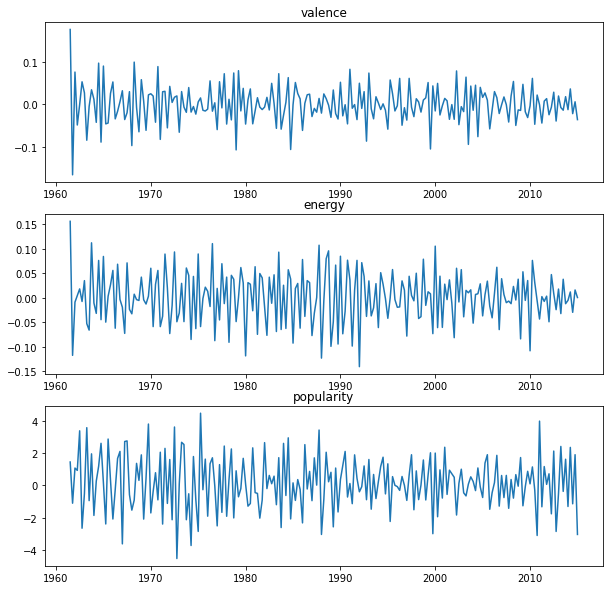

In [31]:
# aquí me muestra la no presencia de correlación serial en los residuos. Es decir son ruido blanco las tres series
results.plot();

También puede comprobarse su correlación serial mediante el test estadístico de Durbin Watson

Este test varía de cero a cuatro, con un valor de 2.0 que indica cero autocorrelación; los valores por debajo de 2.0 significan que hay autocorrelación positiva y por encima de 2.0 indican autocorrelación negativa.

Dado los resultados, parece que hay poca autocorrelación entre los residuos del modelo.

In [33]:
from statsmodels.stats.stattools import durbin_watson   # test de correlación de los residuos

In [34]:
durbin_watson(results.resid)

array([2.07801717, 2.10287365, 2.01559167])

Los residuos individuales tienen que ser ruido blancos, pero juntos deben estar correlacionados.

### Forecast del modelo

Para pronosticar, el modelo VAR espera hasta el número de observaciones de los datos pasados hasta el orden de retraso.

Esto se debe a que los términos en el modelo VAR son esencialmente los retrasos de las diversas series de tiempo en el conjunto de datos, por lo que debe proporcionarle tantos valores anteriores como indique el orden de retraso utilizado por el modelo.

In [35]:
# obtener el número de lags se usaron en entrenamiento
lag_order = results.k_ar

In [36]:
# Input data for forecasting
forecast_input = spotifyD_train.values[-lag_order:]

In [37]:
# Forecast
fc = results.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=spotifyDiff.index[-nobs:], columns=spotifyDiff.columns + '_1d')  #2d
df_forecast.tail(3)

,valence_1d,energy_1d,popularity_1d
release_date,,,
2020-06-30,-0.000666,0.001288,0.163761
2020-09-30,-0.000499,0.001155,0.163866
2020-12-31,-0.000549,0.001178,0.161994


Los pronósticos se generan pero están en la escala de los datos de entrenamiento utilizados por el modelo. Por lo tanto, para volver a subirlo a su escala original, debe desdiferenciarlo tantas veces como haya diferenciado los datos de entrada originales.

```
# Código alternativo
# inverting transformation
def invert_transformation(X_train, pred):
    forecast = pred.copy()
    columns = X_train.columns
    for col in columns:
        forecast[str(col)+'_1d'] = X_train[col].iloc[-1] + forecast[str(col)+'_1d'].cumsum()
    return forecast
```

In [38]:
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

In [39]:
df_results = invert_transformation(spotify_train, df_forecast, second_diff=False)        
df_results.loc[:, ['valence_forecast', 'energy_forecast', 'popularity_forecast']]

,valence_forecast,energy_forecast,popularity_forecast
release_date,,,
2015-03-31,0.471359,0.648912,55.759296
2015-06-30,0.456071,0.640368,55.278186
2015-09-30,0.462934,0.655866,56.336631
2015-12-31,0.447621,0.652867,55.782918
2016-03-31,0.461319,0.650536,56.182010
2016-06-30,0.454663,0.651493,56.152105
2016-09-30,0.457282,0.657999,56.617341
2016-12-31,0.451508,0.656107,56.599381
2017-03-31,0.456071,0.656169,56.795101


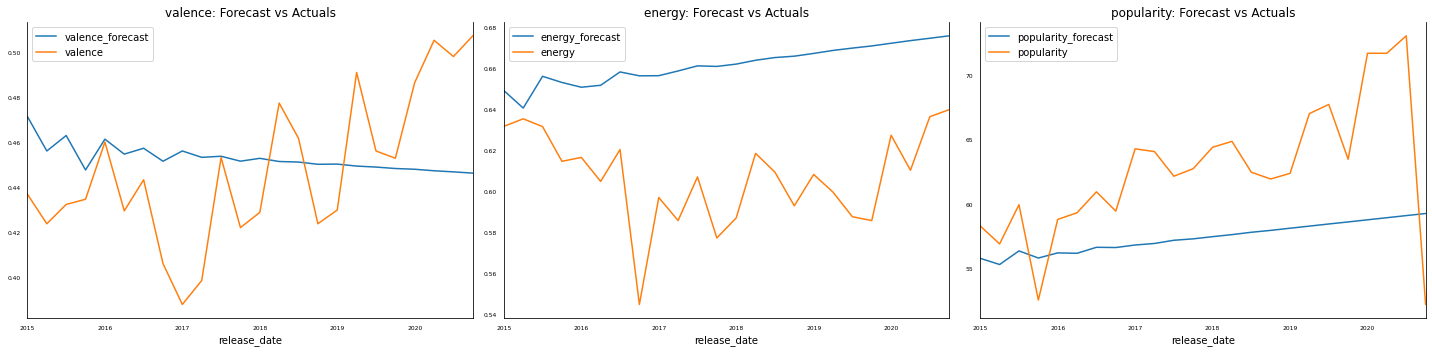

In [40]:
# Grafica de los valores
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

for i, (col,ax) in enumerate(zip(spotify.columns, axes.flatten())):
    df_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    spotify_test[col][-nobs:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

### Evaluación del Modelo

In [41]:
#from statsmodels.tsa.stattools import acf
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax})

In [42]:
print('Forecast Accuracy of: popularity')
accuracy_prod = forecast_accuracy(df_results['popularity_forecast'].values, spotify_test['popularity'])
accuracy_prod

Forecast Accuracy of: popularity


{'corr': 0.5999993614533544,
 'mae': 6.0754313540350395,
 'mape': 0.09427739683805976,
 'me': -5.213795295450056,
 'minmax': 0.09345118070780778,
 'mpe': -0.07779623118794919,
 'rmse': 6.946565492664945}

### Análisis de Impulso Respuesta

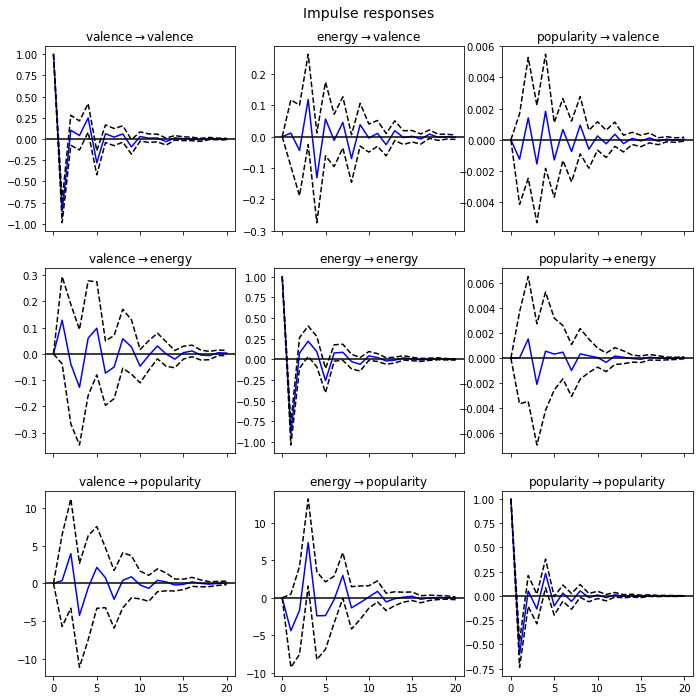

In [43]:
irf = results.irf(20)
irf.plot();

# La línea punteada es el intervalo de confianza
# Cómo la linea azul va reaccionando a lo largo del tiempo ante diferentes shoks que asumo lo hace la variable antes de la flecha
# Como un aumento en danza afecta (aumenta o disminuye) mi valence

### Forecast Error Variance Decomposition

Este es el de analizar la contribución de cada variable al error del pronóstico


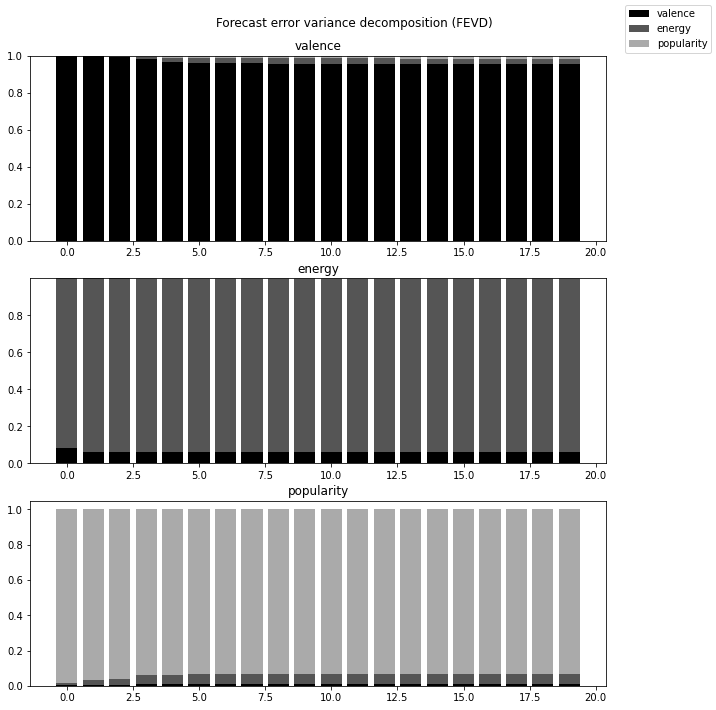

In [44]:
fevd = results.fevd(20)
fevd.plot();

# Experimento con demás variables del dataset

Fue una alarma encontrar que la causalidad en el sentido de Granger comenzaba a darse en una variable, en un sentido, a partir del lag 10 y en todas las variables bidireccionalmente recién a partir del lag 35. Es por esta razón que se corre un corto experimento para descartar una elección incorrecta de variables.

In [45]:
# importación de datos
usecols=['release_date', 'popularity', 'valence', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'mode', 'speechiness', 'tempo']
df = pd.read_csv('spotify_o.csv.zip', usecols=usecols, index_col='release_date', parse_dates=True)

# Reordenando columnas de dataset
df = df[['popularity', 'valence', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'mode', 'speechiness', 'tempo']]

# Eliminado los datos menores a 1960 (inclusive) y agrupándolos según su promedio trimestral
df = df.groupby(pd.Grouper(freq="Q")).mean()
df = df.iloc[160:,]   # 160 para Q, 40 para A
df.head(2)

,popularity,valence,acousticness,danceability,energy,instrumentalness,liveness,loudness,mode,speechiness,tempo
release_date,,,,,,,,,,,
1961-03-31,19.392313,0.498892,0.757922,0.485948,0.328821,0.291932,0.199557,-14.533555,0.712392,0.057992,111.295258
1961-06-30,20.857143,0.675377,0.638500,0.500339,0.485059,0.206208,0.208337,-10.543250,0.803571,0.041105,121.034696


In [46]:
for col in range(len(df.columns)):
  result = adfuller(df[df.columns[col]])
  if result[1] > 0.05 :
    print('{} - Serie es no estacionaria: p-value:{}'.format(df.columns[col], result[1]))
  else:
    print('{} - Serie es estacionaria: p-value:{}'.format(df.columns[col], result[1]))

popularity - Serie es no estacionaria: p-value:0.9434694773420735
valence - Serie es no estacionaria: p-value:0.3980382475045702
acousticness - Serie es estacionaria: p-value:0.00031445797644763583
danceability - Serie es no estacionaria: p-value:0.9837381737218704
energy - Serie es estacionaria: p-value:0.017150791572558437
instrumentalness - Serie es no estacionaria: p-value:0.6660877251065429
liveness - Serie es no estacionaria: p-value:0.12405973929329717
loudness - Serie es no estacionaria: p-value:0.7396659457545655
mode - Serie es no estacionaria: p-value:0.9790543354717904
speechiness - Serie es no estacionaria: p-value:0.9980360336568511
tempo - Serie es no estacionaria: p-value:0.22755562860942868


In [47]:
dfDiff = df.diff().dropna()

In [48]:
max_lags=18
y='popularity'

for i in range(len(dfDiff.columns)-1):
  results=grangercausalitytests(dfDiff[[y,dfDiff.columns[i+1]]], max_lags, verbose=False)
  p_values=[round(results[i+1][0]['ssr_chi2test'][1],4) for i in range(max_lags)]
  print('Column - {} : P_Values - {}'.format(dfDiff.columns[i+1],p_values))

Column - valence : P_Values - [0.5958, 0.7659, 0.8184, 0.855, 0.4707, 0.4197, 0.3401, 0.6093, 0.6299, 0.6726, 0.7519, 0.6322, 0.4372, 0.52, 0.4923, 0.5043, 0.3368, 0.1347]
Column - acousticness : P_Values - [0.5031, 0.2439, 0.4788, 0.6075, 0.7916, 0.8767, 0.9129, 0.9418, 0.9082, 0.8906, 0.8944, 0.9156, 0.9277, 0.7772, 0.6531, 0.7149, 0.7601, 0.7704]
Column - danceability : P_Values - [0.6718, 0.4512, 0.9333, 0.8208, 0.788, 0.9296, 0.949, 0.9522, 0.5479, 0.4522, 0.5093, 0.6104, 0.7935, 0.8736, 0.8724, 0.9099, 0.9031, 0.8046]
Column - energy : P_Values - [0.5991, 0.1356, 0.1363, 0.2195, 0.2115, 0.2297, 0.3461, 0.4382, 0.4644, 0.5467, 0.5901, 0.637, 0.6267, 0.5861, 0.3563, 0.5271, 0.4999, 0.4631]
Column - instrumentalness : P_Values - [0.8209, 0.4396, 0.4727, 0.4883, 0.5627, 0.3739, 0.5386, 0.2089, 0.1203, 0.2669, 0.3622, 0.2265, 0.3913, 0.6113, 0.5526, 0.2189, 0.1873, 0.1163]
Column - liveness : P_Values - [0.4443, 0.4453, 0.4393, 0.5045, 0.5008, 0.6251, 0.8196, 0.8716, 0.8236, 0.9239, 0

In [49]:
maxlag = 2
grangers_causation_matrix(dfDiff, variables = dfDiff.columns)

,popularity_x,valence_x,acousticness_x,danceability_x,energy_x,instrumentalness_x,liveness_x,loudness_x,mode_x,speechiness_x,tempo_x
popularity_y,1.0000,0.5958,0.2439,0.4512,0.1356,0.4396,0.4443,0.0761,0.0767,0.6065,0.2889
valence_y,0.4529,1.0000,0.1510,0.7458,0.1878,0.0219,0.4073,0.6861,0.0324,0.1561,0.5777
acousticness_y,0.2962,0.2322,1.0000,0.0173,0.0806,0.5585,0.1343,0.4443,0.3403,0.6778,0.2972
danceability_y,0.0805,0.7988,0.0621,1.0000,0.3090,0.8282,0.4141,0.5535,0.0102,0.1005,0.3605
energy_y,0.5180,0.0900,0.0849,0.0374,1.0000,0.0407,0.1292,0.0833,0.1781,0.5997,0.5220
instrumentalness_y,0.1964,0.6599,0.6206,0.5554,0.2600,1.0000,0.1495,0.2153,0.0107,0.3906,0.1198
liveness_y,0.4986,0.0453,0.3122,0.2009,0.2235,0.7368,1.0000,0.2390,0.6871,0.1361,0.1019
loudness_y,0.4122,0.3558,0.5173,0.0515,0.0162,0.0050,0.0115,1.0000,0.4701,0.2730,0.6789
mode_y,0.0975,0.2124,0.6769,0.1783,0.3779,0.1442,0.3529,0.7137,1.0000,0.1874,0.6667
speechiness_y,0.7198,0.0054,0.0824,0.1686,0.1060,0.5194,0.1979,0.0832,0.4721,1.0000,0.0035


**Considerando solo dos lags, las variables que parecen causar en el sentido de granger a `energy` son `danceability` e `instrumentalness`**

In [50]:
df_input = dfDiff[['energy','danceability','instrumentalness']]

In [51]:
df_train = df_input[:int(0.9*(len(df_input)))]
df_test = df_input[int(0.9*(len(df_input))):]

In [52]:
model = VAR(df_train, freq="Q")
for i in range(10):
    results = model.fit(i+1)

model.select_order(10).summary()

,AIC,BIC,FPE,HQIC
0,-19.38,-19.33,3.824e-09,-19.36
1,-20.40,-20.20,1.385e-09,-20.32
2,-20.87,-20.53,8.611e-10,-20.74
3,-21.22,-20.74*,6.070e-10,-21.03*
4,-21.23*,-20.60,6.013e-10*,-20.98
5,-21.20,-20.42,6.214e-10,-20.89
6,-21.16,-20.24,6.446e-10,-20.79
7,-21.17,-20.10,6.416e-10,-20.74
8,-21.16,-19.95,6.459e-10,-20.67
9,-21.12,-19.76,6.772e-10,-20.57


## Estimación del orden del modelo

In [53]:
model = VAR(df_train, freq="Q")
results = model.fit(3)

print(results.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 27, Aug, 2021
Time:                     10:45:13
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -20.6152
Nobs:                     212.000    HQIC:                  -20.8982
Log likelihood:           1363.12    FPE:                6.92994e-10
AIC:                     -21.0902    Det(Omega_mle):     6.03501e-10
--------------------------------------------------------------------
Results for equation energy
                         coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------------
const                       0.003285         0.002594            1.267           0.205
L1.energy                  -0.883788         0.066551          -13.280           0.000
L1.danceability             0.14813

**El modelo no cambió *tanto*, solo `instrumentalness` presenta interacción con dos lags de `energy` y sus propios lags. Las demás variables solo dependen de sí mismas**

In [54]:
# pasando en limpio los coeficientes de la ecuación:
variable_y = 'instrumentalness'
df_coeff = pd.DataFrame([results.params[variable_y], results.pvalues[variable_y]]).T
df_coeff.columns = ['coeff','pval']
df_coeff['valid']=np.where(df_coeff['pval'] < 0.05,1, 0)
df_coeff

,coeff,pval,valid
const,-0.001864,3.772704e-01,0
L1.energy,0.099186,6.704432e-02,0
L1.danceability,0.027583,7.681266e-01,0
L1.instrumentalness,-0.906397,1.088383e-41,1
L2.energy,0.138716,2.304558e-02,1
L2.danceability,0.026142,8.111945e-01,0
L2.instrumentalness,-0.634242,1.195193e-15,1
L3.energy,0.132867,1.108448e-02,1
L3.danceability,-0.051513,5.821303e-01,0
L3.instrumentalness,-0.388318,2.372873e-09,1


In [55]:
durbin_watson(results.resid)

array([2.09886182, 2.06528715, 2.14890202])

## Forecast del modelo

In [56]:
# obtener el número de lags se usaron en entrenamiento
lag_order = results.k_ar

In [57]:
# Input data for forecasting
forecast_input = df_train.values[-lag_order:]

In [58]:
# Forecast
nobs = df_test.shape[0]

fc = results.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=df_input.index[-nobs:], columns=df_input.columns + '_1d')
df_forecast

,energy_1d,danceability_1d,instrumentalness_1d
release_date,,,
2015-03-31,-0.001863,-0.000712,-0.040640
2015-06-30,-0.003956,-0.000209,0.010625
2015-09-30,0.012129,0.000234,-0.005071
2015-12-31,-0.004650,0.003680,0.012219
2016-03-31,0.000182,-0.002789,-0.013035
2016-06-30,0.001826,0.001155,0.005162
2016-09-30,0.004383,0.000341,-0.003662
2016-12-31,-0.002004,0.001566,0.004139
2017-03-31,0.001711,-0.001096,-0.004653


**Los pronósticos se generan pero están en la escala de los datos de entrenamiento utilizados por el modelo. Por lo tanto, para volver a subirlo a su escala original, debe desdiferenciarlo tantas veces como haya diferenciado los datos de entrada originales.**

In [59]:
df2 = df[['energy','danceability','instrumentalness']]
df_train2 = df2[:int(0.9*(len(df_input)))]
df_test2 = df2[int(0.9*(len(df_input))):]

In [60]:
df_results = invert_transformation(df_train2, df_forecast, second_diff=False)        
df_results.loc[:, ['energy_forecast', 'danceability_forecast', 'instrumentalness_forecast']]

,energy_forecast,danceability_forecast,instrumentalness_forecast
release_date,,,
2015-03-31,0.646887,0.593076,0.017376
2015-06-30,0.642931,0.592867,0.028001
2015-09-30,0.655060,0.593101,0.022930
2015-12-31,0.650410,0.596781,0.035149
2016-03-31,0.650592,0.593992,0.022115
2016-06-30,0.652418,0.595147,0.027277
2016-09-30,0.656801,0.595487,0.023614
2016-12-31,0.654797,0.597054,0.027753
2017-03-31,0.656508,0.595958,0.023101


**Gráfica de los valores reales y los pronosticados**

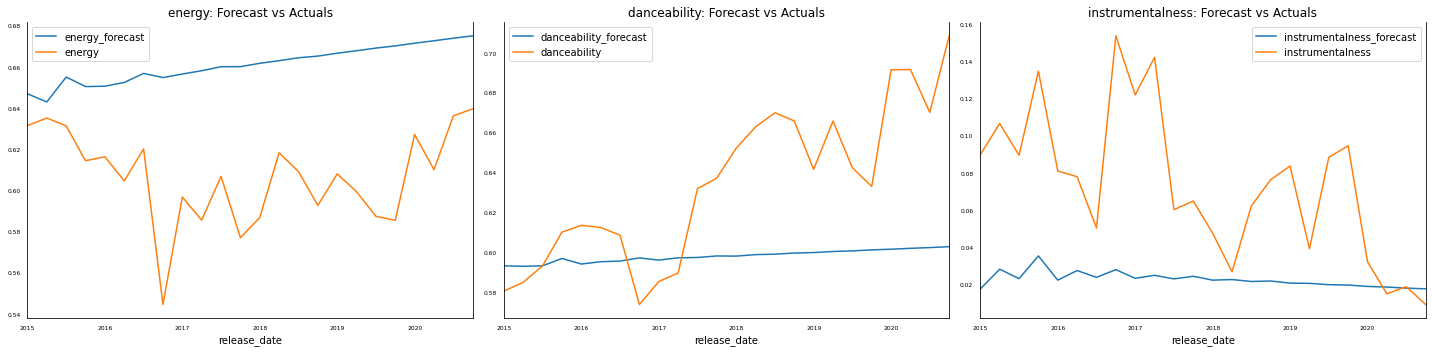

In [61]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

for i, (col,ax) in enumerate(zip(df_input.columns, axes.flatten())):
    df_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    df_test2[col][-nobs:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

## Evaluación del modelo

In [62]:
df_test3 = df_test2.copy()
df_test3 = df_test3.drop(df_test3.index[0])

In [63]:
print('Forecast Accuracy of: instrumentalness')
accuracy_prod = forecast_accuracy(df_results['instrumentalness_forecast'].values, df_test3['instrumentalness'])
accuracy_prod

Forecast Accuracy of: instrumentalness


{'corr': 0.6395997325282462,
 'mae': 0.0520713515524646,
 'mape': 0.6308313960179541,
 'me': -0.051070000687002994,
 'minmax': 0.609975522775684,
 'mpe': -0.53254460759931,
 'rmse': 0.06298976254494157}

# Modelado de series de tiempo multivariante usando Facebook Prophet

Características:

- En el preprocesamiento es importante hacer imputación de valores faltates dado que el algoritmo no lo maneja.
- Parece que necesita a lot of Feature Engineering

## Preprocesamiento de los Datos

In [64]:
from fbprophet import Prophet

In [65]:
spotify.head(3)

,valence,energy,popularity
release_date,,,
1961-03-31,0.498892,0.328821,19.392313
1961-06-30,0.675377,0.485059,20.857143
1961-09-30,0.509076,0.367914,19.751553


In [66]:
# customizando el dataset como el algoritmo lo necesita
df_prophet = spotify.reset_index()[['release_date','valence','energy','popularity']].rename({'release_date':'ds','popularity':'y','valence':'valence','energy':'energy'}, axis='columns')
df_prophet.head(3)

,ds,valence,energy,y
0,1961-03-31,0.498892,0.328821,19.392313
1,1961-06-30,0.675377,0.485059,20.857143
2,1961-09-30,0.509076,0.367914,19.751553


In [67]:
# Split los datos en entrenamiento (95%) y test (5%)
df_prophet_train = df_prophet.loc[:'2017']
df_prophet_test = df_prophet.loc['2018':]

## Entrenamiento del Modelo

In [68]:
m = Prophet()

In [69]:
# Adicionando multiples variables al modelo
m.add_regressor('valence', standardize=False)
m.add_regressor('energy', standardize=False)

In [70]:
m.fit(df_prophet_train)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [71]:
m.params

{'beta': array([[-0.00460694,  0.00481149,  0.00292938,  0.0077133 ,  0.00709415,
          0.00038653, -0.01017344,  0.01566175,  0.00073505,  0.00432081,
          0.00900841,  0.00441182,  0.0072245 , -0.01005838, -0.01368059,
         -0.01525594,  0.00921654, -0.00018583,  0.01574704, -0.00217735,
         -0.00632087,  0.02484135]]),
 'delta': array([[ 1.41176407e-08, -8.14103906e-09, -1.00849239e-03,
         -2.19783310e-01, -4.08006436e-01, -4.39283198e-01,
         -1.29504744e-01, -4.17026691e-09, -7.13278080e-09,
          4.07577032e-09,  4.20663437e-09,  5.83794346e-06,
          1.37279423e-01,  1.62401194e-01,  1.34656033e-01,
          1.62597047e-02,  5.18890129e-08,  6.07844231e-09,
          4.54192049e-08, -6.93296146e-09, -4.15833016e-02,
         -3.65892801e-02, -1.09333594e-03, -2.72091414e-03,
         -7.21703471e-02]]),
 'k': array([[1.36540458]]),
 'm': array([[0.38572636]]),
 'sigma_obs': array([[0.0227955]]),
 'trend': array([[0.38572636, 0.39249647, 0.39

In [72]:
df_prophet_test.tail()

,ds,valence,energy,y
235,2019-12-31,0.452824,0.585462,63.462279
236,2020-03-31,0.486471,0.627107,71.708092
237,2020-06-30,0.505285,0.610041,71.710027
238,2020-09-30,0.498062,0.636154,73.064706
239,2020-12-31,0.507263,0.639600,52.171429


## Predicciones

In [73]:
future = m.make_future_dataframe(periods=df_prophet_test.shape[0], freq='Q')
future.head()

,ds
0,1961-03-31
1,1961-06-30
2,1961-09-30
3,1961-12-31
4,1962-03-31


In [74]:
# reconstruyendo el dataset
future['valence'] = df_prophet['valence']
future['energy'] = df_prophet['energy']

In [75]:
future.head()

,ds,valence,energy
0,1961-03-31,0.498892,0.328821
1,1961-06-30,0.675377,0.485059
2,1961-09-30,0.509076,0.367914
3,1961-12-31,0.585102,0.359326
4,1962-03-31,0.536283,0.363872


In [76]:
# Predicción
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
235,2019-12-31,57.106191,54.975779,59.275368
236,2020-03-31,56.819288,54.730286,58.903202
237,2020-06-30,57.913589,55.795933,59.996062
238,2020-09-30,57.644250,55.473896,59.776052
239,2020-12-31,57.793422,55.493612,60.125464


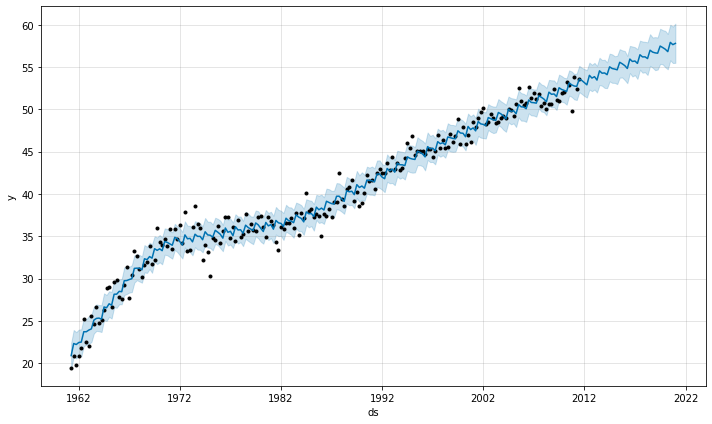

In [77]:
fig1 = m.plot(forecast)

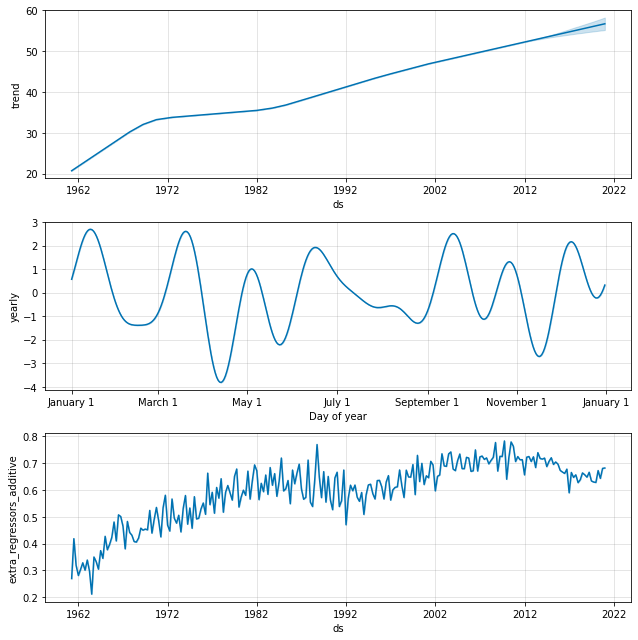

In [78]:
# Al parecer hay una estacionalidad anual, que creo se explica por que cada
# inicio de trimestre hay más lanzamientos de canciones.
fig2 = m.plot_components(forecast)

## Evaluación del modelo

**[Documentación de Diagnóstico de Prophet](https://facebook.github.io/prophet/docs/diagnostics.html)**

In [79]:
from fbprophet.diagnostics import cross_validation, performance_metrics

In [80]:
# horizon should be in the format used by Pandas Timedelta, which accepts units of days or shorter.
cv_results = cross_validation(model = m, horizon = '365 days')
df_p = performance_metrics(cv_results)

INFO:fbprophet:Making 93 forecasts with cutoffs between 1964-07-11 00:00:00 and 2010-06-30 00:00:00


  0%|          | 0/93 [00:00<?, ?it/s]

INFO:fbprophet:n_changepoints greater than number of observations. Using 10.
INFO:fbprophet:n_changepoints greater than number of observations. Using 11.
INFO:fbprophet:n_changepoints greater than number of observations. Using 13.
INFO:fbprophet:n_changepoints greater than number of observations. Using 15.
INFO:fbprophet:n_changepoints greater than number of observations. Using 16.
INFO:fbprophet:n_changepoints greater than number of observations. Using 18.
INFO:fbprophet:n_changepoints greater than number of observations. Using 19.
INFO:fbprophet:n_changepoints greater than number of observations. Using 21.
INFO:fbprophet:n_changepoints greater than number of observations. Using 23.
INFO:fbprophet:n_changepoints greater than number of observations. Using 24.


In [81]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,energy,energy_lower,energy_upper,extra_regressors_additive,extra_regressors_additive_lower,extra_regressors_additive_upper,valence,valence_lower,valence_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1961-03-31,20.743858,19.369480,22.397283,20.743858,20.743858,0.154911,0.154911,0.154911,0.439283,0.439283,0.439283,0.269696,0.269696,0.269696,-0.169587,-0.169587,-0.169587,-0.114785,-0.114785,-0.114785,0.0,0.0,0.0,20.898769
1,1961-06-30,21.107946,20.773093,23.926186,21.107946,21.107946,1.220849,1.220849,1.220849,0.648007,0.648007,0.648007,0.418428,0.418428,0.418428,-0.229580,-0.229580,-0.229580,0.802422,0.802422,0.802422,0.0,0.0,0.0,22.328795
2,1961-09-30,21.476034,20.561288,23.670937,21.476034,21.476034,0.733664,0.733664,0.733664,0.491509,0.491509,0.491509,0.318460,0.318460,0.318460,-0.173049,-0.173049,-0.173049,0.415204,0.415204,0.415204,0.0,0.0,0.0,22.209698
3,1961-12-31,21.844123,20.911489,23.974693,21.844123,21.844123,0.604364,0.604364,0.604364,0.480036,0.480036,0.480036,0.281144,0.281144,0.281144,-0.198893,-0.198893,-0.198893,0.323221,0.323221,0.323221,0.0,0.0,0.0,22.448487
4,1962-03-31,22.204209,20.812132,24.011246,22.204209,22.204209,0.294112,0.294112,0.294112,0.486110,0.486110,0.486110,0.303812,0.303812,0.303812,-0.182298,-0.182298,-0.182298,-0.009700,-0.009700,-0.009700,0.0,0.0,0.0,22.498322
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,2019-12-31,56.243613,54.975779,59.275368,54.941743,57.517023,0.862579,0.862579,0.862579,0.782139,0.782139,0.782139,0.628211,0.628211,0.628211,-0.153928,-0.153928,-0.153928,0.234368,0.234368,0.234368,0.0,0.0,0.0,57.106191
236,2020-03-31,56.367409,54.730286,58.903202,55.021678,57.699523,0.451878,0.451878,0.451878,0.837774,0.837774,0.837774,0.672409,0.672409,0.672409,-0.165365,-0.165365,-0.165365,-0.220531,-0.220531,-0.220531,0.0,0.0,0.0,56.819288
237,2020-06-30,56.491206,55.795933,59.996062,55.088117,57.881307,1.422383,1.422383,1.422383,0.814976,0.814976,0.814976,0.643215,0.643215,0.643215,-0.171761,-0.171761,-0.171761,0.779168,0.779168,0.779168,0.0,0.0,0.0,57.913589
238,2020-09-30,56.616363,55.473896,59.776052,55.131437,58.081926,1.027887,1.027887,1.027887,0.849860,0.849860,0.849860,0.680555,0.680555,0.680555,-0.169305,-0.169305,-0.169305,0.347333,0.347333,0.347333,0.0,0.0,0.0,57.644250


In [82]:
cv_results

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,1964-09-30,22.432940,22.419351,22.445081,28.901345,1964-07-11 00:00:00
1,1964-12-31,24.919466,24.866177,24.969301,29.062500,1964-07-11 00:00:00
2,1965-03-31,25.318733,25.218149,25.416794,26.661371,1964-07-11 00:00:00
3,1965-06-30,30.968720,30.806797,31.125181,29.559322,1964-07-11 00:00:00
4,1965-03-31,28.519060,27.983951,29.039298,26.661371,1965-01-09 12:00:00
...,...,...,...,...,...,...
366,2010-09-30,53.213484,51.505445,54.793913,49.762500,2009-12-29 12:00:00
367,2010-09-30,53.245053,51.620552,54.843226,49.762500,2010-06-30 00:00:00
368,2010-12-31,53.007167,51.422547,54.678011,53.778689,2010-06-30 00:00:00
369,2011-03-31,53.062728,51.420169,54.552317,52.449143,2010-06-30 00:00:00


In [85]:
print('Forecast Accuracy of: popularity')
accuracy_prod = forecast_accuracy(forecast['yhat'].values, spotify['popularity'])
accuracy_prod

Forecast Accuracy of: popularity


{'corr': 0.9725916902529771,
 'mae': 1.5576391305972896,
 'mape': 0.03415416272073364,
 'me': -0.6306814660388075,
 'minmax': 0.03346591322443959,
 'mpe': -0.008086795236356298,
 'rmse': 2.7406265999036057}

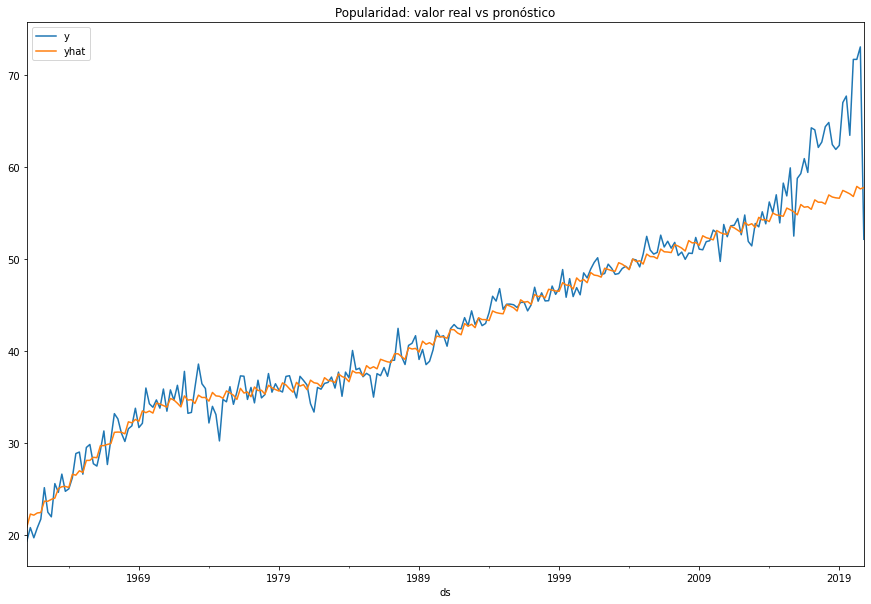

In [106]:
#@title
predf1 = df_prophet.copy()
predf1.ds = pd.to_datetime(predf1.ds)
predf1.set_index('ds', inplace=True)

predf2 = forecast.copy()
predf2.ds = pd.to_datetime(predf2.ds)
predf2.set_index('ds', inplace=True)

comparar = pd.concat([predf1, predf2], axis=1)
popularidad = comparar[['y','yhat']]

popularidad.plot(figsize=(15, 10), title = 'Popularidad: valor real vs pronóstico');